# [Original Sklearn Blog](https://scikit-learn.org/stable/modules/grid_search.html)

Any parameter provided when constructing an estimator may be optimized in this manner. Specifically, to find the names and current values for all parameters for a given estimator, use: `estimator.get_params()`

However, hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

It is possible and recommended to search the hyper-parameter space for the best cross validation score.

A search consists of:
* an estimator (regressor or classifier such as `sklearn.svm.SVC()` );
* a parameter space;
* a method for searching or sampling candidates;
* a cross-validation scheme; and
* a score function.

Two generic approaches to parameter search are provided in scikit-learn: for given values, **GridSearchCV** exhaustively considers all parameter combinations, while **RandomizedSearchCV** can sample a given number of candidates from a parameter space with a specified distribution. Both these tools have successive halving counterparts **HalvingGridSearchCV** and **HalvingRandomSearchCV**, which can be much faster at finding a good parameter combination.

After describing these tools we detail best practices applicable to these approaches. Some models allow for specialized, efficient parameter search strategies, outlined in Alternatives to brute force parameter search.


Note that it is common that a small subset of those parameters can have a large impact on the predictive or computation performance of the model while others can be left to their default values. It is recommended to read the docstring of the estimator class to get a finer understanding of their expected behavior, possibly by reading the enclosed reference to the literature.

# 3.2.1. Exhaustive Grid Search
The grid search provided by `GridSearchCV` exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter. For instance, the following param_grid:
```
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
```
specifies that two grids should be explored: one with a linear kernel and C values in [1, 10, 100, 1000], and the second one with an RBF kernel, and the cross-product of C values ranging in [1, 10, 100, 1000] and gamma values in [0.001, 0.0001].

The GridSearchCV instance implements the usual estimator API: when `fitting` it on a dataset all the possible combinations of parameter values are evaluated and the best combination is retained.

### Function: `GridSearchCV(estimator: estimator object, param_grid: dict)`

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Loading the Digits dataset
X, y = datasets.load_digits(return_X_y=True)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("#### Tuning hyper-parameters for %s ####" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

#### Tuning hyper-parameters for precision ####

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.028) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.974 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 10, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 100, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are co

# 3.2.2. Randomized Parameter Optimization

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favorable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

1. A budget can be chosen independent of the number of parameters and possible values.
2. Adding parameters that do not influence the performance does not decrease efficiency.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for GridSearchCV. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the n_iter parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified:

```
{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}
```
This example uses the `scipy.stats` module, which contains many useful distributions for sampling parameters, such as expon, gamma, uniform or randint.


## Comparing randomized search and grid search for hyperparameter estimation

In [6]:
import numpy as np

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier

# get some data
X, y = load_digits(return_X_y=True, n_class=3)

# build a classifier
clf = SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {
    "average": [True, False],
    "l1_ratio": stats.uniform(0, 1),
    "alpha": loguniform(1e-2, 1e0),
}

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time()
random_search.fit(X, y)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)

RandomizedSearchCV took 0.33 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.980 (std: 0.015)
Parameters: {'alpha': 0.015757262959578446, 'average': False, 'l1_ratio': 0.7067912760239121}

Model with rank: 2
Mean validation score: 0.978 (std: 0.015)
Parameters: {'alpha': 0.05805547627888239, 'average': False, 'l1_ratio': 0.5301848683492129}

Model with rank: 3
Mean validation score: 0.978 (std: 0.013)
Parameters: {'alpha': 0.049168384464703986, 'average': False, 'l1_ratio': 0.09419857572729695}

GridSearchCV took 1.74 seconds for 60 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.989 (std: 0.009)
Parameters: {'alpha': 1.0, 'average': False, 'l1_ratio': 0.0}

Model with rank: 2
Mean validation score: 0.989 (std: 0.011)
Parameters: {'alpha': 0.01, 'average': False, 'l1_ratio': 0.2222222222222222}

Model with rank: 3
Mean validation score: 0.987 (std: 0.013)
Parameters: {'alpha': 0.01, 'average': False, 'l1_ratio': 0.3333

# 3.2.3. Searching for optimal parameters with successive halving

Scikit-learn also provides the `HalvingGridSearchCV` and `HalvingRandomSearchCV` estimators that can be used to search a parameter space using successive halving. Successive halving (SH) is like a tournament among candidate parameter combinations. SH is an iterative selection process where all candidates (the parameter combinations) are evaluated with a small amount of resources at the first iteration. Only some of these candidates are selected for the next iteration, which will be allocated more resources. For parameter tuning, the resource is typically the number of training samples, but it can also be an arbitrary numeric parameter such as `n_estimators` in a random forest.

As illustrated in the figure below, **only a subset of candidates *‘survive’* until the last iteration**. These are the candidates that have consistently ranked among the top-scoring candidates across all iterations. Each iteration is allocated an increasing amount of resources per candidate, here the number of samples.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_successive_halving_iterations_001.png' width=60%>

We here briefly describe the main parameters, but each parameter and their interactions are described in more details in the sections below. The factor (> 1) parameter controls the rate at which the resources grow, and the rate at which the number of candidates decreases. In each iteration, the number of resources per candidate is multiplied by factor and the number of candidates is divided by the same factor. Along with resource and min_resources, factor is the most important parameter to control the search in our implementation, though a value of 3 usually works well. factor effectively controls the number of iterations in HalvingGridSearchCV and the number of candidates (by default) and iterations in HalvingRandomSearchCV. aggressive_elimination=True can also be used if the number of available resources is small. More control is available through tuning the min_resources parameter.

## Comparison between grid search and successive halving

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


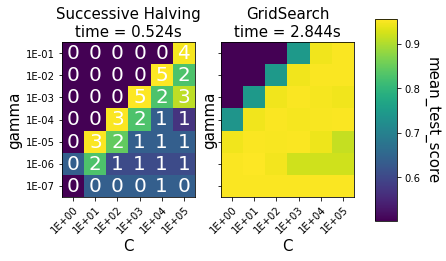

In [7]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

rng = np.random.RandomState(0)
X, y = datasets.make_classification(n_samples=1000, random_state=rng)

gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

clf = SVC(random_state=rng)

tic = time()
gsh = HalvingGridSearchCV(
    estimator=clf, param_grid=param_grid, factor=2, random_state=rng
)
gsh.fit(X, y)
gsh_time = time() - tic

tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic

def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame.from_dict(gs.cv_results_)
    results["params_str"] = results.params.apply(str)
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values("iter").pivot_table(
            index="param_gamma",
            columns="param_C",
            values="mean_test_score",
            aggfunc="last",
        )
    else:
        scores_matrix = results.pivot(
            index="param_gamma", columns="param_C", values="mean_test_score"
        )

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in Cs])
    ax.set_xlabel("C", fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in gammas])
    ax.set_ylabel("gamma", fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(
            index="param_gamma", columns="param_C", values="iter", aggfunc="max"
        ).values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(
                    j,
                    i,
                    iterations[i, j],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=20,
                )

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel("mean_test_score", rotation=-90, va="bottom", fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title("Successive Halving\ntime = {:.3f}s".format(gsh_time), fontsize=15)
ax2.set_title("GridSearch\ntime = {:.3f}s".format(gs_time), fontsize=15)

plt.show()